In [12]:
# !pip install apyori

[Dataset](https://www.kaggle.com/c/instacart-market-basket-analysis)

O conjunto de dados contém mais de 3 milhões de transações de supermercado, compreendendo uma enorme variedade de produtos de diferentes departamentos. A concorrência lidava com a previsão de quais produtos encomendados anteriormente por um cliente seriam adicionados ao próximo pedido. O foco deste projeto foi a exploração de dados e geração de regras de associação.

A geração de regras foi feita com base em duas coleções de dados: hábitos de compra (dia e hora, intervalo entre pedidos) e associação de produtos (quais produtos tendem a ser vendidos juntos).

In [13]:
import pandas as pd
import numpy as np
from apyori import apriori
from collections import Counter
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt

## Analisando todos os dados do dataset

### `aisles.csv`
Corredores do mercado 


In [14]:
aisles = pd.read_csv('data/raw/aisles.csv')

In [15]:
aisles.dtypes # Tipos de dados 

aisle_id     int64
aisle       object
dtype: object

In [16]:
aisles.head() # Nomes dos corredores

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [17]:
aisles.isna().sum(axis = 0) # Não há valores nulos.

aisle_id    0
aisle       0
dtype: int64

### `departments.csv`
Departamentos do mercado

In [18]:
departments = pd.read_csv('data/raw/departments.csv')

In [19]:
departments.dtypes

department_id     int64
department       object
dtype: object

In [20]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [21]:
departments.shape # Total de departamentos

(21, 2)

### `products.csv`

Produtos cadastrados no mercado

In [22]:
products = pd.read_csv('data/raw/products.csv')

In [23]:
products.dtypes

product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

In [24]:
products.head()

# Modelos relacionais 
# "aisle_id" = corredor onde se encontra o produto
# "department_id" = departamento onde se encontra o produto

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [25]:
# Exemplo
 
aisles[aisles['aisle_id'] == 61]

,aisle_id,aisle
60,61,cookies cakes


In [26]:
departments[departments['department_id'] == 19]

,department_id,department
18,19,snacks


In [27]:
products.describe()

# menor id = 1
# maior id = 49688
# são 134 corredores
# são 21 departamentos

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [28]:
products.shape

(49688, 4)

In [29]:
# Confirmando total de itens 
len(set(products.product_id))  # ids únicos 

49688

In [30]:
len(products.product_id.unique())

49688

In [31]:
products.isna().sum(axis = 0)

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

### `orders.csv`

Compras realizadas pelos clientes

In [32]:
orders = pd.read_csv('data/raw/orders.csv')

In [33]:
orders.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

*order_id - Id do pedido            
*user_id  - Id do usuário              
*eval_set     -  Separação dos dados. Usaremos os prior.       
*order_number -  Número do pedido          
*order_dow    -  DOW = Day Of Week. Em que dia da semana foi feita a compra. Inicia no 0 e termina no 6.          
*order_hour_of_day       - Hora do dia que foi feita a compra      
*days_since_prior_order  - Quantos dias se passaram desde a última compra. 

In [34]:
orders.head(11) # Cliente 1 iniciou sua compra (NaN) e fez 10 compras.

# Atenção ao dado NaN: não é nulo e sim ausente, neste caso, 
# pois mostra que é a primeira compra do cliente.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [35]:
orders.shape

(3421083, 7)

In [36]:
orders.eval_set.value_counts() # Não usaremos dados de treino e teste.
# Aparentemente, ela so mostra a localização de cada item.

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [37]:
# Só usaremos os dados de "prior".
 
orders = orders[orders.eval_set == 'prior']
orders.shape

(3214874, 7)

In [38]:
orders.drop('eval_set', axis = 1, inplace=True) # Como só temos os "prior", podemos excluir esta coluna.

In [39]:
orders.describe()

# O usuário faz, no mínimo, 1 pedido e, no máximo, 99 pelo dataset(order_number). 
# (Isso pode ser uma restrição de quem coletou esses dados)
# "days_since_prior_order" - mínimo: compra recorrente no mesmo dia. máximo: 30 dias de intervalo.
# "order_hour_of_day" - mercado aparenta ser 24 horas.


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.214874e+06,3.008665e+06
mean,1.710827e+06,1.029701e+05,1.719107e+01,2.776364e+00,1.344347e+01,1.070724e+01
std,9.875206e+05,5.953411e+04,1.779950e+01,2.041806e+00,4.226246e+00,8.954180e+00
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.556832e+05,5.138500e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.711120e+06,1.026620e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.566034e+06,1.543720e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,9.900000e+01,6.000000e+00,2.300000e+01,3.000000e+01


In [40]:
len(set(orders.user_id)) # Quantidade de clientes nesse dataset

206209

In [41]:
orders.isna().sum(axis = 0) # O days_since_prior_order são NaN 

# Motivo: ser a primeira compra dos 206209 clientes.

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [42]:
orders.loc[orders.days_since_prior_order.isna()] # Visualização do NaN da 1º compra.

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
11,2168274,2,1,2,11,NaN
26,1374495,3,1,1,14,NaN
39,3343014,4,1,6,11,NaN
45,2717275,5,1,3,12,NaN
...,...,...,...,...,...,...
3420930,969311,206205,1,4,12,NaN
3420934,3189322,206206,1,3,18,NaN
3421002,2166133,206207,1,6,19,NaN
3421019,2227043,206208,1,1,15,NaN


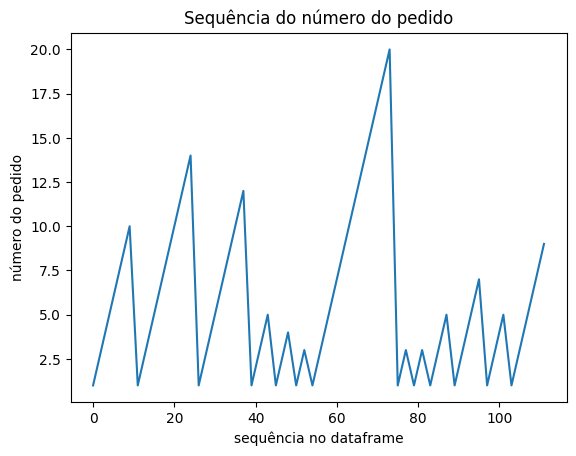

In [43]:
# Grafiamente, podemos ententender a compra de cada cliente.
 
plt.plot(orders.order_number[:100]) #! filtrando apenas 100 clientes
plt.title('Sequência do número do pedido')
plt.xlabel('sequência no dataframe')
plt.ylabel('número do pedido'); 

# 1º usuário comprou 10 pedidos, o segundo quase 15 etc.

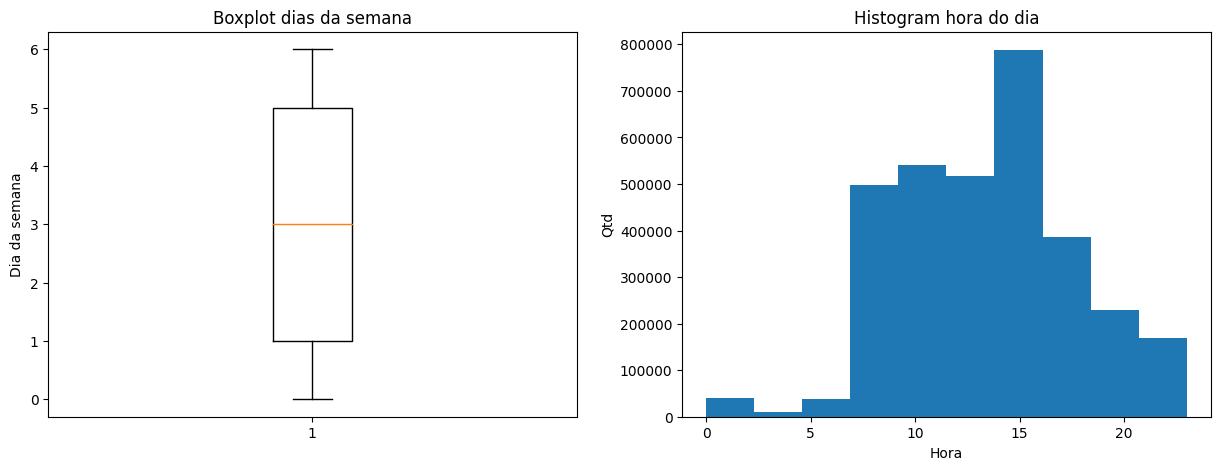

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].boxplot(orders.order_dow)
ax[0].set_title('Boxplot dias da semana')
ax[0].set_ylabel('Dia da semana')
ax[1].hist(orders.order_hour_of_day)
ax[1].set_title('Histogram hora do dia')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Qtd');

# O 3º dia tem a media do melhor dia de compras.
# Às 15 horas temos o melhor horario de vendas. 

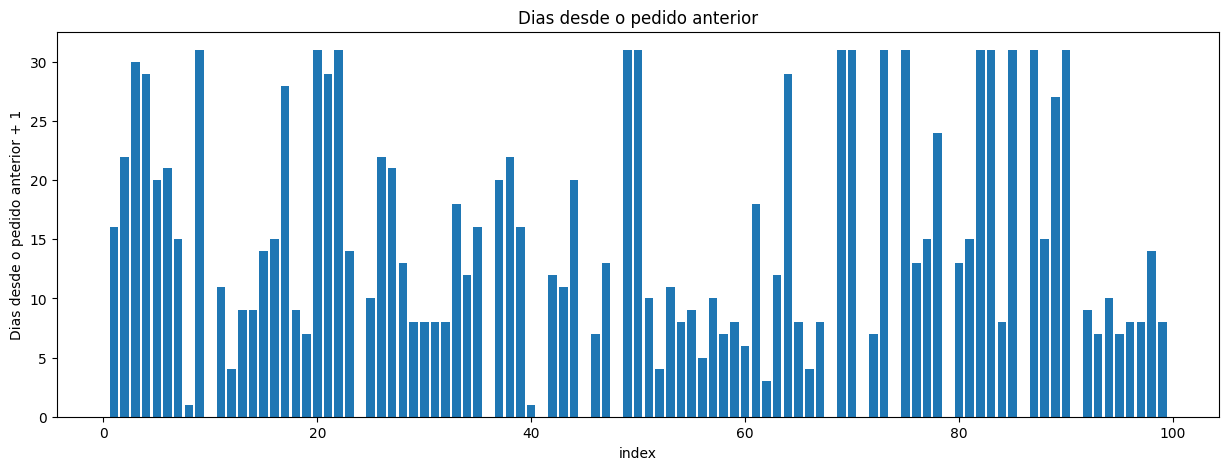

In [45]:
plt.figure(figsize = (15,5))
plt.bar(range(100), orders.days_since_prior_order[:100] + 1)
plt.title('Dias desde o pedido anterior')
plt.xlabel('index')
plt.ylabel('Dias desde o pedido anterior + 1');

# Quantidade de produto que cada cliente comprou. Frequência ou intervalo de cada compra.
# O espaço em branco é a mudança de cliente, significa o NaN. 

### `order_products(__prior).csv`

Ordens com divisão de dados para prior. 

In [46]:
order_products = pd.read_csv('data/raw/order_products__prior.csv')

In [47]:
order_products.dtypes

order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtype: object

In [48]:
order_products.head(11)

# "Order_id" indica também o cliente
# "Add_to_cart" - ordem que o produto foi adicionado ao carrinho
# "Reordered" (não tem a ver com organização) - significa que já foi comprado pelo cliente alguma vez (recompra)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [49]:
order_products.shape # Mais de 32 milhões de produtos vendidos.

(32434489, 4)

In [50]:
len(set(order_products.order_id)) # Número de pedidos: aproximadamente 3,2 milhões.

3214874

In [51]:
order_products.isna().sum(axis=0) # Não há valor nulo.

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

## Exploração dos dados

### **DATAFRAME *orders***

In [52]:
orders_apriori = orders.copy()

**Filtros por  *User***

In [53]:
# Teremos a quantidade de compras de cada usuário

orders_by_user = orders.groupby('user_id')['order_number'].max()

In [54]:
# "add_to_card_order" nos diz - além da ordem de compra - a quantidade de itens comprados.
# Logo, usando merge, podemos atribuir a cada usuário a quantidade de produto comprado.
    
products_by_user = orders[['order_id', 'user_id']].merge(
    order_products[['order_id', 'add_to_cart_order']].groupby('order_id').max()
    .rename({'add_to_cart_order': 'order_size'}, axis=1), on='order_id'
)

In [55]:
products_by_user.head(3)

,order_id,user_id,order_size
0,2539329,1,5
1,2398795,1,6
2,473747,1,5


In [56]:
# Exemplo desse filtro de agrupamento de quantidade de compras por usuário
products_by_user[products_by_user.order_id==10]

,order_id,user_id,order_size
2113619,10,135442,15


In [57]:
# Somatório total de quantidade de produtos por usuário
 
products_by_user = products_by_user.drop('order_id', axis=1).groupby('user_id')['order_size'].sum()

In [58]:
# Quantidade de compras de cada cliente
products_by_user.head(3)

user_id
1     59
2    195
3     88
Name: order_size, dtype: int64

In [59]:
# O usuário que mais fez compra, comprou 99 produtos.
 
max(orders_by_user)

99

In [60]:
# O usuário que menos fez compra, comprou 3 produtos.
 
min(orders_by_user)

3

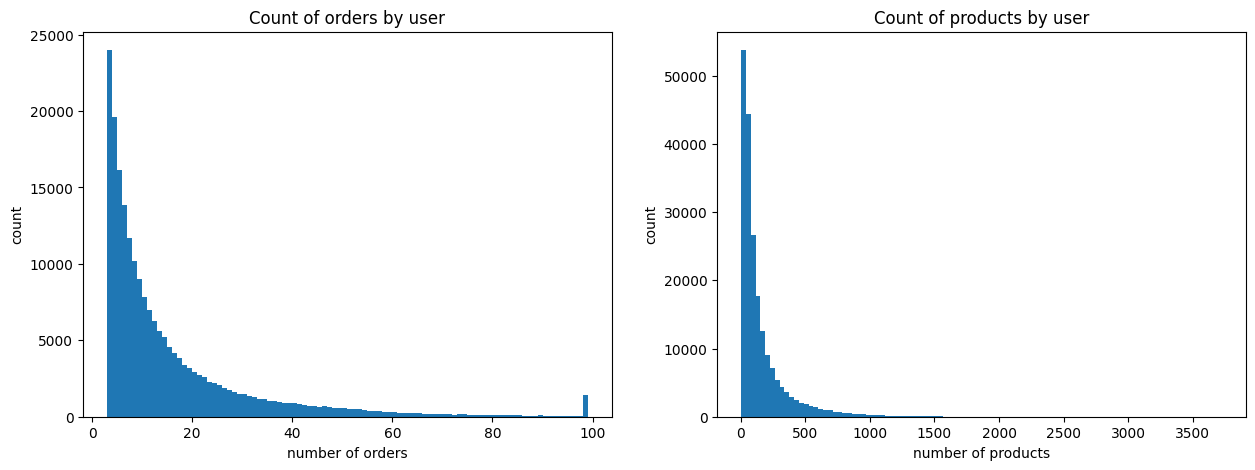

In [61]:
# Visualização da distribuição de compras por usuário e quantidade compradas.

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(orders_by_user, bins = max(orders_by_user) - min(orders_by_user)) #! range 
ax[0].set_title('Count of orders by user')
ax[0].set_xlabel('number of orders')
ax[0].set_ylabel('count')

ax[1].hist(products_by_user, bins = 100)
ax[1].set_title('Count of products by user')
ax[1].set_xlabel('number of products')
ax[1].set_ylabel('count');

**O gráfico da esquerda** 

Nos mostra que há uma curva exponencial. Também é possível perceber que há uma limitação nesse dataset de 99 pedidos: se um consumidor tiver feito 120 pedidos, por exemplo, ele muda para 99. Qualquer valor acima de 99, ele considera como 99 pedidos. Por isso temos esse pico no 99: aproximadamente 1000 pessoas (que compraram, no mínimo, 99 produtos no mercado). Pelo gráfico, fica claro que a maior concentração dos clientes está abaixo de 20 compras. Ou seja: temos um grupo novo de clientes nesse mercado muito grande.

**O gráfico da direita**

Poucos clientes compraram mais de 1500 produtos. A maioria dos clientes comprou (no total) entre 150 a 250 produtos.

In [62]:
# Drop de colunas "id" para deixar o dataframe pronto para análises.

orders_apriori.drop(['user_id','order_id'], axis=1, inplace=True)
orders_apriori.head(3)

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,2,8,NaN
1,2,3,7,15.0
2,3,3,12,21.0


**Filtros por *Order number***

In [63]:
orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,2,8,NaN
1,2398795,1,2,3,7,15.0
2,473747,1,3,3,12,21.0
3,2254736,1,4,4,7,29.0
4,431534,1,5,4,15,28.0


In [64]:
# Contagem  de frequência de compra 
'''Temos 206209 usuários ativos. Então, o que podemos ver é que todos os usuários 
fazem pelo menos 3 compras nesse mercado, depois vai diminuindo. Por exemplo, 
1374 pessoas compram 99 vezes.'''
 
orders_by_order_number = orders.order_number.value_counts()
orders_by_order_number

1     206209
2     206209
3     206209
4     182223
5     162633
       ...  
95      1592
96      1525
97      1471
98      1421
99      1374
Name: order_number, Length: 99, dtype: int64

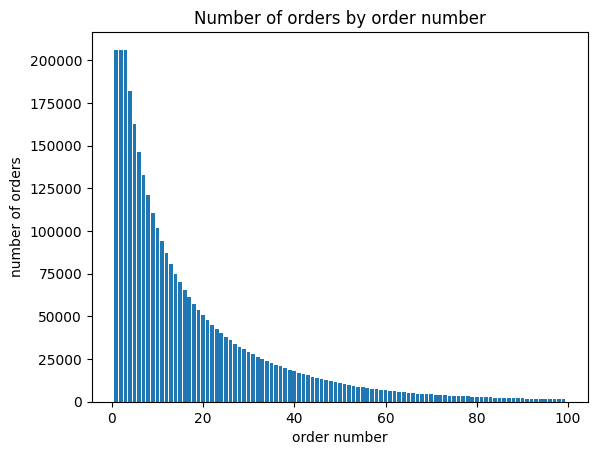

In [65]:
# Plot desse filtro

plt.bar(orders_by_order_number.index, orders_by_order_number)
plt.title('Number of orders by order number')
plt.xlabel('order number')
plt.ylabel('number of orders');

**ATENÇÃO**

Para regras de associação, não podemos ter dados númericos e sim categóricos. 
Logo, precisamos modificar o "order_number" para categórico. Assim, essa faixa de 3 a 99 
deve ser categórica: criamos um função para estas categorias abaixo:

In [66]:
def order_number_categorical(order_number):
  if order_number in range(3):
    return 'order_number_1-3'
  if order_number in range(3, 5):
    return 'order_number_4-5'
  if order_number in range(5, 10):
    return 'order_number_6-10'
  if order_number in range(10, 20):
    return 'order_number_11-20'
  if order_number in range(20, 40):
    return 'order_number_21-40'
  if order_number in range(40, 60):
    return 'order_number_41-60'
  if order_number >= 60:
    return 'order_number_60+'

In [67]:
orders_apriori.order_number = orders_apriori.order_number.map(order_number_categorical)

In [68]:
orders_apriori.head()

,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,order_number_1-3,2,8,NaN
1,order_number_1-3,3,7,15.0
2,order_number_4-5,3,12,21.0
3,order_number_4-5,4,7,29.0
4,order_number_6-10,4,15,28.0
